<a href="https://colab.research.google.com/github/eunicean/Proyecto3-Paralela/blob/main/proyecto3_paralela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/eunicean/Proyecto3-Paralela.git

Cloning into 'Proyecto3-Paralela'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 1.47 MiB | 19.08 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [4]:
!apt-get install -y libpng-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libpng-dev is already the newest version (1.6.37-3build5).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [5]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp8j_k1x57".


In [6]:
# Detect selected GPU and its NVIDA architecture:
import subprocess
gpu_info = subprocess.getoutput("nvidia-smi --query-gpu=name,compute_cap --format=csv,noheader,nounits")
if "not found" in gpu_info.lower(): raise RuntimeError("Error: No GPU found. Please select a GPU runtime environment.")
gpu_name, compute_cap = map(str.strip, gpu_info.split(','))
gpu_arch = f"sm_{compute_cap.replace('.', '')}"

print(f"{'GPU Name':<15}: {gpu_name}")
print(f"{'Architecture':<15}: {gpu_arch}")

GPU Name       : Tesla T4
Architecture   : sm_75


In [7]:
%%writefile pgm.h
#ifndef PGM_H
#define PGM_H

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

class PGMImage {
public:
    int x_dim, y_dim;
    unsigned char *pixels;

    PGMImage(const char *filename) {
        FILE *file = fopen(filename, "rb");
        if (!file) {
            printf("Error: No se pudo abrir el archivo %s\n", filename);
            x_dim = y_dim = 0;
            pixels = NULL;
            return;
        }

        char magic[3];
        fscanf(file, "%2s\n", magic);

        // Saltar comentarios
        char c = getc(file);
        while (c == '#') {
            while (getc(file) != '\n');
            c = getc(file);
        }
        ungetc(c, file);

        fscanf(file, "%d %d\n", &x_dim, &y_dim);
        int maxVal;
        fscanf(file, "%d\n", &maxVal);

        pixels = new unsigned char[x_dim * y_dim];
        fread(pixels, sizeof(unsigned char), x_dim * y_dim, file);
        fclose(file);
    }

    ~PGMImage() {
        if (pixels) delete[] pixels;
    }
};

#endif

Writing pgm.h


In [8]:
%%writefile houghBase.cu
/*
 ============================================================================
 Author        : G. Barlas
 Version       : 1.0
 Last modified : December 2014
 License       : Released under the GNU GPL 3.0
 Description   :
 To build use  : make
 ============================================================================
 */

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#include <string.h>
#include "pgm.h"
#include <png.h>

const int degreeInc = 2;
const int degreeBins = 180 / degreeInc;
const int rBins = 200;
const float radInc = degreeInc * M_PI / 180;

//*****************************************************************
// Función para guardar imagen PNG
int savePNG(const char* filename, unsigned char* data, int w, int h) {
    FILE *fp = fopen(filename, "wb");
    if (!fp) {
        printf("No se pudo abrir el archivo para escribir: %s\n", filename);
        return -1;
    }

    png_structp png_ptr = png_create_write_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
    if (!png_ptr) {
        fclose(fp);
        return -1;
    }

    png_infop info_ptr = png_create_info_struct(png_ptr);
    if (!info_ptr) {
        png_destroy_write_struct(&png_ptr, NULL);
        fclose(fp);
        return -1;
    }

    if (setjmp(png_jmpbuf(png_ptr))) {
        png_destroy_write_struct(&png_ptr, &info_ptr);
        fclose(fp);
        return -1;
    }

    png_init_io(png_ptr, fp);

    // Configurar header PNG (RGB, 8 bits por canal)
    png_set_IHDR(png_ptr, info_ptr, w, h, 8, PNG_COLOR_TYPE_RGB,
                 PNG_INTERLACE_NONE, PNG_COMPRESSION_TYPE_DEFAULT,
                 PNG_FILTER_TYPE_DEFAULT);

    png_write_info(png_ptr, info_ptr);

    // Preparar filas para libpng
    png_bytep *row_pointers = (png_bytep*)malloc(sizeof(png_bytep) * h);
    for (int y = 0; y < h; y++) {
        row_pointers[y] = (png_byte*)malloc(png_get_rowbytes(png_ptr, info_ptr));
        memcpy(row_pointers[y], data + y * w * 3, w * 3);
    }

    png_write_image(png_ptr, row_pointers);
    png_write_end(png_ptr, NULL);

    // Liberar memoria
    for (int y = 0; y < h; y++) {
        free(row_pointers[y]);
    }
    free(row_pointers);
    png_destroy_write_struct(&png_ptr, &info_ptr);
    fclose(fp);

    printf("Imagen PNG guardada: %s\n", filename);
    return 0;
}


// Función para dibujar una línea en la imagen
void drawLine(unsigned char* colorImg, int w, int h, float r, float theta,
              unsigned char r_val, unsigned char g_val, unsigned char b_val) {
    int xCent = w / 2;
    int yCent = h / 2;

    float cos_theta = cos(theta);
    float sin_theta = sin(theta);

    // Dibujar línea iterando por todas las posibles posiciones
    // Método 1: Iterar sobre X
    if (fabs(sin_theta) > 0.001) {  // Línea no horizontal
        for (int x = 0; x < w; x++) {
            // Coordenadas centradas
            int xCoord = x - xCent;

            // Ecuación de Hough: r = xCoord * cos(θ) + yCoord * sin(θ)
            // Despejamos: yCoord = (r - xCoord * cos(θ)) / sin(θ)
            float yCoord = (r - xCoord * cos_theta) / sin_theta;

            // Convertir a coordenadas de imagen
            int y = yCent - (int)round(yCoord);

            // Dibujar con grosor (± 1 pixel)
            for (int dy = -1; dy <= 1; dy++) {
                int py = y + dy;
                if (py >= 0 && py < h && x >= 0 && x < w) {
                    int idx = (py * w + x) * 3;
                    colorImg[idx] = r_val;
                    colorImg[idx + 1] = g_val;
                    colorImg[idx + 2] = b_val;
                }
            }
        }
    }

    // Método 2: Iterar sobre Y (para líneas casi verticales)
    if (fabs(cos_theta) > 0.001) {  // Línea no vertical
        for (int y = 0; y < h; y++) {
            // Coordenadas centradas
            int yCoord = yCent - y;

            // Ecuación: xCoord = (r - yCoord * sin(θ)) / cos(θ)
            float xCoord = (r - yCoord * sin_theta) / cos_theta;

            // Convertir a coordenadas de imagen
            int x = (int)round(xCoord) + xCent;

            // Dibujar con grosor
            for (int dx = -1; dx <= 1; dx++) {
                int px = x + dx;
                if (px >= 0 && px < w && y >= 0 && y < h) {
                    int idx = (y * w + px) * 3;
                    colorImg[idx] = r_val;
                    colorImg[idx + 1] = g_val;
                    colorImg[idx + 2] = b_val;
                }
            }
        }
    }
}

//*****************************************************************
// The CPU function returns a pointer to the accummulator
void CPU_HoughTran (unsigned char *pic, int w, int h, int **acc)
{
  float rMax = sqrt (1.0 * w * w + 1.0 * h * h) / 2;
  *acc = new int[rBins * degreeBins];
  memset (*acc, 0, sizeof (int) * rBins * degreeBins);
  int xCent = w / 2;
  int yCent = h / 2;
  float rScale = 2 * rMax / rBins;

  printf("rMax CPU: %.6f\n", rMax);
  printf("rScale CPU: %.6f\n", rScale);

  for (int i = 0; i < w; i++)
    for (int j = 0; j < h; j++)
      {
        int idx = j * w + i;
        if (pic[idx] > 0)
          {
            int xCoord = i - xCent;
            int yCoord = yCent - j;
            float theta = 0;
            for (int tIdx = 0; tIdx < degreeBins; tIdx++)
              {
                float r = xCoord * cos (theta) + yCoord * sin (theta);
                // cambio para usar floorf para consistencia con GPU
                float normalized_r = (r + rMax) / rScale;
                int rIdx = (int)floorf(normalized_r);
                // cambio para Verificar límites como en GPU
                if (rIdx >= 0 && rIdx < rBins) {
                  (*acc)[rIdx * degreeBins + tIdx]++;
                }
                theta += radInc;
              }
          }
      }
}

// GPU kernel. One thread per image pixel is spawned.
// The accummulator memory needs to be allocated by the host in global memory
__global__ void GPU_HoughTran (unsigned char *pic, int w, int h, int *acc, float rMax, float rScale, float *d_Cos, float *d_Sin)
{
  int gloID = blockIdx.x * blockDim.x + threadIdx.x;
  if (gloID >= w * h) return;

  int xCent = w / 2;
  int yCent = h / 2;

  int i = gloID % w;
  int j = gloID / w;

  int xCoord = i - xCent;
  int yCoord = yCent - j;

  if (pic[gloID] > 0)
  {
    for (int tIdx = 0; tIdx < degreeBins; tIdx++)
    {
      float r = xCoord * d_Cos[tIdx] + yCoord * d_Sin[tIdx];

      // Cálculo más preciso de rIdx - MANTENER ESTO
      float normalized_r = (r + rMax) / rScale;
      int rIdx = (int)floorf(normalized_r);

      // Verificación más estricta - MANTENER ESTO
      if (rIdx >= 0 && rIdx < rBins) {
        int acc_index = rIdx * degreeBins + tIdx;
        atomicAdd(acc + acc_index, 1);
      }
    }
  }
}

//*****************************************************************
int main (int argc, char **argv)
{
  if (argc < 2) {
    printf("Uso: %s <archivo.pgm>\n", argv[0]);
    return 1;
  }

  PGMImage inImg (argv[1]);
  int w = inImg.x_dim;
  int h = inImg.y_dim;

  // verificar pixeles
  printf("Dimensiones imagen: %d x %d\n", w, h);

  float* d_Cos;
  float* d_Sin;

  cudaMalloc ((void **) &d_Cos, sizeof (float) * degreeBins);
  cudaMalloc ((void **) &d_Sin, sizeof (float) * degreeBins);

  // CPU calculation
  int *cpuht;
  CPU_HoughTran(inImg.pixels, w, h, &cpuht);

  // pre-compute values to be stored
  float *pcCos = (float *) malloc (sizeof (float) * degreeBins);
  float *pcSin = (float *) malloc (sizeof (float) * degreeBins);
  float rad = 0;
  for (int i = 0; i < degreeBins; i++)
  {
    pcCos[i] = cos (rad);
    pcSin[i] = sin (rad);
    rad += radInc;
  }

  float rMax = sqrt (1.0 * w * w + 1.0 * h * h) / 2;
  float rScale = 2 * rMax / rBins;

  // TODO eventualmente volver memoria global
  cudaMemcpy(d_Cos, pcCos, sizeof (float) * degreeBins, cudaMemcpyHostToDevice);
  cudaMemcpy(d_Sin, pcSin, sizeof (float) * degreeBins, cudaMemcpyHostToDevice);

  // setup and copy data from host to device
  unsigned char *d_in, *h_in;
  int *d_hough, *h_hough;

  h_in = inImg.pixels;

  h_hough = (int *) malloc (degreeBins * rBins * sizeof (int));

  cudaMalloc ((void **) &d_in, sizeof (unsigned char) * w * h);
  cudaMalloc ((void **) &d_hough, sizeof (int) * degreeBins * rBins);
  cudaMemcpy (d_in, h_in, sizeof (unsigned char) * w * h, cudaMemcpyHostToDevice);
  cudaMemset (d_hough, 0, sizeof (int) * degreeBins * rBins);

  // execution configuration uses a 1-D grid of 1-D blocks, each made of 256 threads
  //1 thread por pixel
  int blockNum = (w * h + 255) / 256;

  // Record elapsed time using CUDA events - Dan
  cudaEvent_t start, stop;
  cudaEventCreate (&start);
  cudaEventCreate (&stop);

  cudaEventRecord(start);
  GPU_HoughTran <<< blockNum, 256 >>> (d_in, w, h, d_hough, rMax, rScale, d_Cos, d_Sin);
  cudaEventRecord(stop);

  cudaEventSynchronize(stop);

  // CAMBIO para Verificar errores de CUDA después del kernel
  cudaError_t err = cudaGetLastError();
  if (err != cudaSuccess) {
    printf("Error CUDA después del kernel: %s\n", cudaGetErrorString(err));
  }

  float elapsedTime = 0;
  cudaEventElapsedTime(&elapsedTime, start, stop);

  // get results from device
  cudaMemcpy (h_hough, d_hough, sizeof (int) * degreeBins * rBins, cudaMemcpyDeviceToHost);

  // EJERCICIO 4: Generar imagen con líneas detectadas
  printf("\n EJERCICIO 4: Generando imagen con líneas detectadas \n");

  // Crear imagen en color (3 canales)
  unsigned char* colorImg = (unsigned char*)malloc(w * h * 3 * sizeof(unsigned char));

  // Convertir imagen original a escala de grises en color
  for (int i = 0; i < w * h; i++) {
    unsigned char gray_val = inImg.pixels[i];
    colorImg[i * 3] = gray_val;     // Rojo
    colorImg[i * 3 + 1] = gray_val; // Verde
    colorImg[i * 3 + 2] = gray_val; // Azul
  }

  // Calcular estadísticas para determinar threshold
  int max_votes = 0;
  long long sum_votes = 0;
  int non_zero_count = 0;

  for (int i = 0; i < degreeBins * rBins; i++) {
    if (h_hough[i] > 0) {
      sum_votes += h_hough[i];
      non_zero_count++;
      if (h_hough[i] > max_votes) {
        max_votes = h_hough[i];
      }
    }
  }

  double mean_votes = (non_zero_count > 0) ? (double)sum_votes / non_zero_count : 0;

  // Calcular desviación estándar
  double sum_sq_diff = 0;
  for (int i = 0; i < degreeBins * rBins; i++) {
    if (h_hough[i] > 0) {
      double diff = h_hough[i] - mean_votes;
      sum_sq_diff += diff * diff;
    }
  }
  double std_dev = (non_zero_count > 0) ? sqrt(sum_sq_diff / non_zero_count) : 0;

  int threshold = 2100;
  printf("Estadísticas del acumulador:\n");
  printf("  Máximo: %d\n", max_votes);
  printf("  Media: %.2f\n", mean_votes);
  printf("  Desviación estándar: %.2f\n", std_dev);
  printf("  Threshold usado: %d\n", threshold);

  // Encontrar y dibujar líneas que superen el threshold
  int lines_drawn = 0;
  for (int rIdx = 0; rIdx < rBins; rIdx++) {
    for (int tIdx = 0; tIdx < degreeBins; tIdx++) {
      int acc_index = rIdx * degreeBins + tIdx;
      if (h_hough[acc_index] > threshold) {
        // Convertir índices a valores reales de r y theta
        float r = (rIdx * rScale) - rMax;
        float theta = tIdx * radInc;

        // Dibujar línea en rojo
        drawLine(colorImg, w, h, r, theta, 255, 0, 0);
        lines_drawn++;

        //printf("Línea detectada: r=%.2f, θ=%.2f°, votos=%d\n",
        //     r, theta * 180 / M_PI, h_hough[acc_index]);

        // Limitar número de líneas dibujadas para no saturar
        if (lines_drawn >= 150) break;
      }
    }
    if (lines_drawn >= 150) break;
  }

  printf("Líneas dibujadas: %d\n", lines_drawn);

  // Guardar imagen resultante como PNG
  savePNG("output_with_lines.png", colorImg, w, h);

  // Liberar memoria de la imagen en color
  free(colorImg);

  // compare CPU and GPU results
  printf("\n Verificación de resultados n");
  int errors = 0;
  for (int i = 0; i < degreeBins * rBins; i++)
  {
    if (cpuht[i] != h_hough[i]) {
      printf ("\nDiferencia en [%i]: CPU=%i, GPU=%i\n", i, cpuht[i], h_hough[i]);
      errors++;
      if (errors > 10) break;
    }
  }

  if (errors == 0) {
    printf("Resultados correctos! CPU == GPU\n");
  } else {
    printf("Cantidad de errores: %d\n", errors);
  }

  printf("Tiempo GPU: %.3f ms\n", elapsedTime);
  printf("Done!\n");

  // Liberar memoria
  free(pcCos);
  free(pcSin);
  free(cpuht);
  free(h_in);
  free(h_hough);

  cudaFree(d_Cos);
  cudaFree(d_Sin);
  cudaFree(d_in);
  cudaFree(d_hough);

  return 0;
}

Writing houghBase.cu


In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import os
def before_and_after(pgm_path, png_path):

    try:
        # Verificar que los archivos existan
        if not os.path.exists(pgm_path):
            print(f" Error: No se encontró '{pgm_path}'")
            return
        if not os.path.exists(png_path):
            print(f" Error: No se encontró '{png_path}'")
            return

        # imagenes
        img_original = Image.open(pgm_path)
        img_result = Image.open(png_path)

        # Crear figura con dos subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # original
        axes[0].imshow(img_original, cmap='gray')
        axes[0].set_title('ANTES:', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        axes[0].text(0.5, -0.05, f'Dimensiones: {img_original.size[0]}×{img_original.size[1]}',
                     ha='center', transform=axes[0].transAxes, fontsize=10)

        # lienas
        axes[1].imshow(img_result)
        axes[1].set_title('DESPUÉS:', fontsize=14, fontweight='bold', color='red')
        axes[1].axis('off')
        axes[1].text(0.5, -0.05, f'Transformada de Hough',
                     ha='center', transform=axes[1].transAxes, fontsize=10, color='red')

        # Título general
        fig.suptitle('Detección de Líneas con Transformada de Hough',
                     fontsize=16, fontweight='bold', y=0.98)

        plt.tight_layout()
        plt.show()


    except Exception as e:
        print(f" Error al mostrar la comparación: {e}")



In [10]:
!nvcc -arch=sm_70 houghBase.cu -o hough -lpng

In [11]:
!./hough /content/Proyecto3-Paralela/runway.pgm

Dimensiones imagen: 800 x 600
rMax CPU: 500.000000
rScale CPU: 5.000000

 EJERCICIO 4: Generando imagen con líneas detectadas 
Estadísticas del acumulador:
  Máximo: 2461
  Media: 775.58
  Desviación estándar: 511.97
  Threshold usado: 2100
Líneas dibujadas: 62
Imagen PNG guardada: output_with_lines.png

 Verificación de resultados n
Diferencia en [3242]: CPU=722, GPU=721

Diferencia en [3332]: CPU=706, GPU=707

Diferencia en [3693]: CPU=706, GPU=705

Diferencia en [3783]: CPU=757, GPU=758

Diferencia en [8169]: CPU=1475, GPU=1476

Diferencia en [8259]: CPU=1532, GPU=1531

Diferencia en [10819]: CPU=1031, GPU=1032

Diferencia en [10909]: CPU=1087, GPU=1086

Diferencia en [11871]: CPU=862, GPU=863

Diferencia en [11961]: CPU=941, GPU=940

Diferencia en [12224]: CPU=841, GPU=840
Cantidad de errores: 11
Tiempo GPU: 1.421 ms
Done!


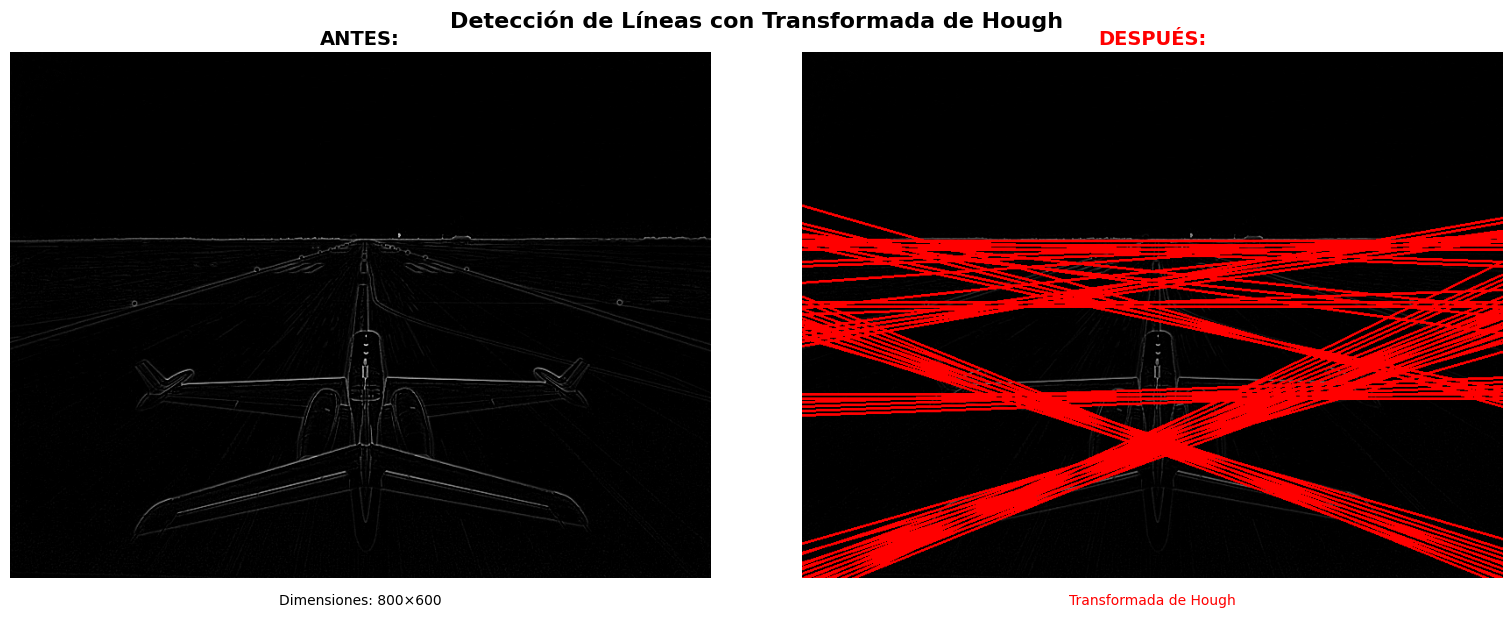

In [12]:
before_and_after(
    pgm_path='/content/Proyecto3-Paralela/runway.pgm',
    png_path='output_with_lines.png'
)

### Inciso 5

In [13]:
%%writefile houghConst.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#include <string.h>
#include "pgm.h"
#include <png.h>

const int degreeInc = 2;
const int degreeBins = 180 / degreeInc;
const int rBins = 200;
const float radInc = degreeInc * M_PI / 180;

// Declaración de memoria CONSTANTE
__constant__ float d_Cos[degreeBins];
__constant__ float d_Sin[degreeBins];

int savePNG(const char* filename, unsigned char* data, int w, int h) {
    FILE *fp = fopen(filename, "wb");
    if (!fp) {
        printf("No se pudo abrir el archivo para escribir: %s\n", filename);
        return -1;
    }

    png_structp png_ptr = png_create_write_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
    if (!png_ptr) { fclose(fp); return -1; }

    png_infop info_ptr = png_create_info_struct(png_ptr);
    if (!info_ptr) {
        png_destroy_write_struct(&png_ptr, NULL);
        fclose(fp);
        return -1;
    }

    if (setjmp(png_jmpbuf(png_ptr))) {
        png_destroy_write_struct(&png_ptr, &info_ptr);
        fclose(fp);
        return -1;
    }

    png_init_io(png_ptr, fp);
    png_set_IHDR(png_ptr, info_ptr, w, h, 8, PNG_COLOR_TYPE_RGB,
                 PNG_INTERLACE_NONE, PNG_COMPRESSION_TYPE_DEFAULT,
                 PNG_FILTER_TYPE_DEFAULT);
    png_write_info(png_ptr, info_ptr);

    png_bytep *row_pointers = (png_bytep*)malloc(sizeof(png_bytep) * h);
    for (int y = 0; y < h; y++) {
        row_pointers[y] = (png_byte*)malloc(png_get_rowbytes(png_ptr, info_ptr));
        memcpy(row_pointers[y], data + y * w * 3, w * 3);
    }

    png_write_image(png_ptr, row_pointers);
    png_write_end(png_ptr, NULL);

    for (int y = 0; y < h; y++) free(row_pointers[y]);
    free(row_pointers);
    png_destroy_write_struct(&png_ptr, &info_ptr);
    fclose(fp);
    printf("Imagen PNG guardada: %s\n", filename);
    return 0;
}

// Función para dibujar una línea en la imagen
void drawLine(unsigned char* colorImg, int w, int h, float r, float theta,
              unsigned char r_val, unsigned char g_val, unsigned char b_val) {
    int xCent = w / 2;
    int yCent = h / 2;

    float cos_theta = cos(theta);
    float sin_theta = sin(theta);

    // Dibujar línea iterando por todas las posibles posiciones
    // parte 1: Iterar sobre X
    if (fabs(sin_theta) > 0.001) {  // Línea no horizontal
        for (int x = 0; x < w; x++) {
            // Coordenadas centradas
            int xCoord = x - xCent;

            // Ecuación de Hough: r = xCoord * cos(θ) + yCoord * sin(θ)
            // Despejamos: yCoord = (r - xCoord * cos(θ)) / sin(θ)
            float yCoord = (r - xCoord * cos_theta) / sin_theta;

            // Convertir a coordenadas de imagen
            int y = yCent - (int)round(yCoord);

            // Dibujar con grosor (± 1 pixel)
            for (int dy = -1; dy <= 1; dy++) {
                int py = y + dy;
                if (py >= 0 && py < h && x >= 0 && x < w) {
                    int idx = (py * w + x) * 3;
                    colorImg[idx] = r_val;
                    colorImg[idx + 1] = g_val;
                    colorImg[idx + 2] = b_val;
                }
            }
        }
    }

    // parte 2: Iterar sobre Y (para líneas casi verticales)
    if (fabs(cos_theta) > 0.001) {  // Línea no vertical
        for (int y = 0; y < h; y++) {
            // Coordenadas centradas
            int yCoord = yCent - y;

            // Ecuación: xCoord = (r - yCoord * sin(θ)) / cos(θ)
            float xCoord = (r - yCoord * sin_theta) / cos_theta;

            // Convertir a coordenadas de imagen
            int x = (int)round(xCoord) + xCent;

            // Dibujar con grosor
            for (int dx = -1; dx <= 1; dx++) {
                int px = x + dx;
                if (px >= 0 && px < w && y >= 0 && y < h) {
                    int idx = (y * w + px) * 3;
                    colorImg[idx] = r_val;
                    colorImg[idx + 1] = g_val;
                    colorImg[idx + 2] = b_val;
                }
            }
        }
    }
}

void CPU_HoughTran(unsigned char *pic, int w, int h, int **acc)
{
    float rMax = sqrt(1.0 * w * w + 1.0 * h * h) / 2;
    *acc = new int[rBins * degreeBins];
    memset(*acc, 0, sizeof(int) * rBins * degreeBins);
    int xCent = w / 2;
    int yCent = h / 2;
    float rScale = 2 * rMax / rBins;

    for (int i = 0; i < w; i++)
        for (int j = 0; j < h; j++) {
            int idx = j * w + i;
            if (pic[idx] > 0) {
                int xCoord = i - xCent;
                int yCoord = yCent - j;
                float theta = 0;
                for (int tIdx = 0; tIdx < degreeBins; tIdx++) {
                    float r = xCoord * cos(theta) + yCoord * sin(theta);
                    float normalized_r = (r + rMax) / rScale;
                    int rIdx = (int)floorf(normalized_r);
                    if (rIdx >= 0 && rIdx < rBins) {
                        (*acc)[rIdx * degreeBins + tIdx]++;
                    }
                    theta += radInc;
                }
            }
        }
}


__global__ void GPU_HoughTranConst(unsigned char *pic, int w, int h, int *acc, float rMax, float rScale)
{
    int gloID = blockIdx.x * blockDim.x + threadIdx.x;
    if (gloID >= w * h) return;

    int xCent = w / 2;
    int yCent = h / 2;

    int i = gloID % w;
    int j = gloID / w;

    int xCoord = i - xCent;
    int yCoord = yCent - j;

    if (pic[gloID] > 0)
    {
        for (int tIdx = 0; tIdx < degreeBins; tIdx++)
        {
            float r = xCoord * d_Cos[tIdx] + yCoord * d_Sin[tIdx];
            float normalized_r = (r + rMax) / rScale;
            int rIdx = (int)floorf(normalized_r);
            if (rIdx >= 0 && rIdx < rBins) {
                int acc_index = rIdx * degreeBins + tIdx;
                atomicAdd(acc + acc_index, 1);
            }
        }
    }
}

int main(int argc, char **argv)
{
    if (argc < 2) {
        printf("Uso: %s <archivo.pgm>\n", argv[0]);
        return 1;
    }

    PGMImage inImg(argv[1]);
    int w = inImg.x_dim;
    int h = inImg.y_dim;

    printf("Dimensiones imagen: %d x %d\n", w, h);

    // CPU precálculo de senos y cosenos
    float *pcCos = (float *)malloc(sizeof(float) * degreeBins);
    float *pcSin = (float *)malloc(sizeof(float) * degreeBins);
    float rad = 0;
    for (int i = 0; i < degreeBins; i++) {
        pcCos[i] = cos(rad);
        pcSin[i] = sin(rad);
        rad += radInc;
    }

    // Copiar senos y cosenos a memoria CONSTANTE
    cudaMemcpyToSymbol(d_Cos, pcCos, sizeof(float) * degreeBins);
    cudaMemcpyToSymbol(d_Sin, pcSin, sizeof(float) * degreeBins);

    float rMax = sqrt(1.0 * w * w + 1.0 * h * h) / 2;
    float rScale = 2 * rMax / rBins;

    int *cpuht;
    CPU_HoughTran(inImg.pixels, w, h, &cpuht);

    unsigned char *d_in;
    int *d_hough;
    int *h_hough = (int *)malloc(degreeBins * rBins * sizeof(int));

    cudaMalloc((void **)&d_in, sizeof(unsigned char) * w * h);
    cudaMalloc((void **)&d_hough, sizeof(int) * degreeBins * rBins);
    cudaMemcpy(d_in, inImg.pixels, sizeof(unsigned char) * w * h, cudaMemcpyHostToDevice);
    cudaMemset(d_hough, 0, sizeof(int) * degreeBins * rBins);

    // Configuración CUDA
    int blockNum = (w * h + 255) / 256;
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Lanzar kernel con memoria constante
    cudaEventRecord(start);
    GPU_HoughTranConst<<<blockNum, 256>>>(d_in, w, h, d_hough, rMax, rScale);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("Error CUDA después del kernel: %s\n", cudaGetErrorString(err));
    }

    float elapsedTime = 0;
    cudaEventElapsedTime(&elapsedTime, start, stop);

    // Obtener resultados
    cudaMemcpy(h_hough, d_hough, sizeof(int) * degreeBins * rBins, cudaMemcpyDeviceToHost);

    // Estadisticas del acumulador
    int max_votes = 0;
    long long sum_votes = 0;
    int non_zero_count = 0;

    for (int i = 0; i < degreeBins * rBins; i++) {
        if (h_hough[i] > 0) {
            sum_votes += h_hough[i];
            non_zero_count++;
            if (h_hough[i] > max_votes)
                max_votes = h_hough[i];
        }
    }

    double mean_votes = (non_zero_count > 0) ? (double)sum_votes / non_zero_count : 0;
    double sum_sq_diff = 0;
    for (int i = 0; i < degreeBins * rBins; i++) {
        if (h_hough[i] > 0) {
            double diff = h_hough[i] - mean_votes;
            sum_sq_diff += diff * diff;
        }
    }
    double std_dev = (non_zero_count > 0) ? sqrt(sum_sq_diff / non_zero_count) : 0;
    int threshold = 2100;

    printf("Estadísticas del acumulador:\n");
    printf("  Máximo: %d\n", max_votes);
    printf("  Media: %.2f\n", mean_votes);
    printf("  Desviación estándar: %.2f\n", std_dev);
    printf("  Threshold usado: %d\n", threshold);

    // Dibujar líneas
    unsigned char* colorImg = (unsigned char*)malloc(w * h * 3 * sizeof(unsigned char));
    for (int i = 0; i < w * h; i++) {
        unsigned char val = inImg.pixels[i];
        colorImg[i * 3] = val;
        colorImg[i * 3 + 1] = val;
        colorImg[i * 3 + 2] = val;
    }

    int lines_drawn = 0;
    for (int rIdx = 0; rIdx < rBins; rIdx++) {
        for (int tIdx = 0; tIdx < degreeBins; tIdx++) {
            int acc_index = rIdx * degreeBins + tIdx;
            if (h_hough[acc_index] > threshold) {
                float r = (rIdx * rScale) - rMax;
                float theta = tIdx * radInc;
                drawLine(colorImg, w, h, r, theta, 255, 0, 0);
                lines_drawn++;
                if (lines_drawn >= 150) break;
            }
        }
        if (lines_drawn >= 150) break;
    }

    printf("Líneas dibujadas: %d\n", lines_drawn);
    savePNG("output_const_lines.png", colorImg, w, h);

    // Comparar CPU y GPU
    printf("\nVerificación de resultados\n");
    int errors = 0;
    for (int i = 0; i < degreeBins * rBins; i++) {
        if (cpuht[i] != h_hough[i]) {
            printf("Diferencia en [%d]: CPU=%d, GPU=%d\n", i, cpuht[i], h_hough[i]);
            errors++;
            if (errors > 10) break;
        }
    }

    if (errors == 0)
        printf("Resultados correctos! CPU == GPU\n");
    else
        printf("Cantidad de errores: %d\n", errors);

    printf("Tiempo GPU (memoria constante): %.3f ms\n", elapsedTime);
    printf("Done!\n");


    // Liberar memoria
    free(pcCos);
    free(pcSin);
    free(cpuht);
    free(colorImg);
    free(h_hough);
    cudaFree(d_in);
    cudaFree(d_hough);

    return 0;
}

Writing houghConst.cu


In [14]:
!nvcc -arch=sm_70 houghConst.cu -o houghConst -lpng

In [15]:
!./houghConst /content/Proyecto3-Paralela/runway.pgm

Dimensiones imagen: 800 x 600
Estadísticas del acumulador:
  Máximo: 2461
  Media: 775.58
  Desviación estándar: 511.97
  Threshold usado: 2100
Líneas dibujadas: 62
Imagen PNG guardada: output_const_lines.png

Verificación de resultados
Diferencia en [3242]: CPU=722, GPU=721
Diferencia en [3332]: CPU=706, GPU=707
Diferencia en [3693]: CPU=706, GPU=705
Diferencia en [3783]: CPU=757, GPU=758
Diferencia en [8169]: CPU=1475, GPU=1476
Diferencia en [8259]: CPU=1532, GPU=1531
Diferencia en [10819]: CPU=1031, GPU=1032
Diferencia en [10909]: CPU=1087, GPU=1086
Diferencia en [11871]: CPU=862, GPU=863
Diferencia en [11961]: CPU=941, GPU=940
Diferencia en [12224]: CPU=841, GPU=840
Cantidad de errores: 11
Tiempo GPU (memoria constante): 1.217 ms
Done!


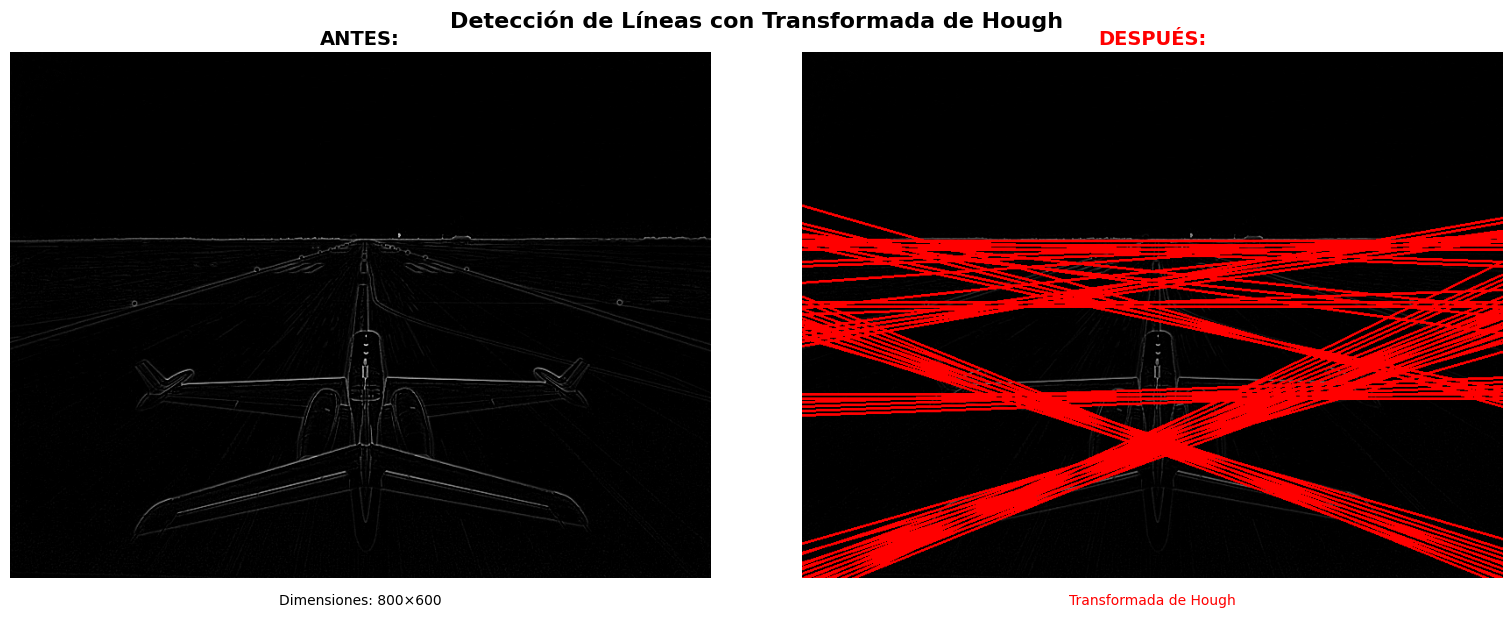

In [16]:
before_and_after(
    pgm_path='/content/Proyecto3-Paralela/runway.pgm',
    png_path='output_const_lines.png'
)


# Memoria Compartida
Punto 8 y 9


In [62]:
%%writefile houghShared.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#include <string.h>
#include "pgm.h"
#include <png.h>

const int degreeInc = 2;
const int degreeBins = 180 / degreeInc;
const int rBins = 100;  // Reducido para caber en memoria compartida
const float radInc = degreeInc * M_PI / 180;

// Declaración de memoria CONSTANTE
__constant__ float d_Cos[degreeBins];
__constant__ float d_Sin[degreeBins];

int savePNG(const char* filename, unsigned char* data, int w, int h) {
    FILE *fp = fopen(filename, "wb");
    if (!fp) {
        printf("No se pudo abrir el archivo para escribir: %s\n", filename);
        return -1;
    }

    png_structp png_ptr = png_create_write_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
    if (!png_ptr) { fclose(fp); return -1; }

    png_infop info_ptr = png_create_info_struct(png_ptr);
    if (!info_ptr) {
        png_destroy_write_struct(&png_ptr, NULL);
        fclose(fp);
        return -1;
    }

    if (setjmp(png_jmpbuf(png_ptr))) {
        png_destroy_write_struct(&png_ptr, &info_ptr);
        fclose(fp);
        return -1;
    }

    png_init_io(png_ptr, fp);
    png_set_IHDR(png_ptr, info_ptr, w, h, 8, PNG_COLOR_TYPE_RGB,
                 PNG_INTERLACE_NONE, PNG_COMPRESSION_TYPE_DEFAULT,
                 PNG_FILTER_TYPE_DEFAULT);
    png_write_info(png_ptr, info_ptr);

    png_bytep *row_pointers = (png_bytep*)malloc(sizeof(png_bytep) * h);
    for (int y = 0; y < h; y++) {
        row_pointers[y] = (png_byte*)malloc(png_get_rowbytes(png_ptr, info_ptr));
        memcpy(row_pointers[y], data + y * w * 3, w * 3);
    }

    png_write_image(png_ptr, row_pointers);
    png_write_end(png_ptr, NULL);

    for (int y = 0; y < h; y++) free(row_pointers[y]);
    free(row_pointers);
    png_destroy_write_struct(&png_ptr, &info_ptr);
    fclose(fp);
    printf("Imagen PNG guardada: %s\n", filename);
    return 0;
}

// Función para dibujar una línea en la imagen
void drawLine(unsigned char* colorImg, int w, int h, float r, float theta,
              unsigned char r_val, unsigned char g_val, unsigned char b_val) {
    int xCent = w / 2;
    int yCent = h / 2;

    float cos_theta = cos(theta);
    float sin_theta = sin(theta);

    // Dibujar línea iterando por todas las posibles posiciones
    // parte 1: Iterar sobre X
    if (fabs(sin_theta) > 0.001) {  // Línea no horizontal
        for (int x = 0; x < w; x++) {
            // Coordenadas centradas
            int xCoord = x - xCent;

            // Ecuación de Hough: r = xCoord * cos(θ) + yCoord * sin(θ)
            // Despejamos: yCoord = (r - xCoord * cos(θ)) / sin(θ)
            float yCoord = (r - xCoord * cos_theta) / sin_theta;

            // Convertir a coordenadas de imagen
            int y = yCent - (int)round(yCoord);

            // Dibujar con grosor (± 1 pixel)
            for (int dy = -1; dy <= 1; dy++) {
                int py = y + dy;
                if (py >= 0 && py < h && x >= 0 && x < w) {
                    int idx = (py * w + x) * 3;
                    colorImg[idx] = r_val;
                    colorImg[idx + 1] = g_val;
                    colorImg[idx + 2] = b_val;
                }
            }
        }
    }

    // parte 2: Iterar sobre Y (para líneas casi verticales)
    if (fabs(cos_theta) > 0.001) {  // Línea no vertical
        for (int y = 0; y < h; y++) {
            // Coordenadas centradas
            int yCoord = yCent - y;

            // Ecuación: xCoord = (r - yCoord * sin(θ)) / cos(θ)
            float xCoord = (r - yCoord * sin_theta) / cos_theta;

            // Convertir a coordenadas de imagen
            int x = (int)round(xCoord) + xCent;

            // Dibujar con grosor
            for (int dx = -1; dx <= 1; dx++) {
                int px = x + dx;
                if (px >= 0 && px < w && y >= 0 && y < h) {
                    int idx = (y * w + px) * 3;
                    colorImg[idx] = r_val;
                    colorImg[idx + 1] = g_val;
                    colorImg[idx + 2] = b_val;
                }
            }
        }
    }
}

void CPU_HoughTran(unsigned char *pic, int w, int h, int **acc)
{
    float rMax = sqrt(1.0 * w * w + 1.0 * h * h) / 2;
    *acc = new int[rBins * degreeBins];
    memset(*acc, 0, sizeof(int) * rBins * degreeBins);
    int xCent = w / 2;
    int yCent = h / 2;
    float rScale = 2 * rMax / rBins;

    for (int i = 0; i < w; i++)
        for (int j = 0; j < h; j++) {
            int idx = j * w + i;
            if (pic[idx] > 0) {
                int xCoord = i - xCent;
                int yCoord = yCent - j;
                float theta = 0;
                for (int tIdx = 0; tIdx < degreeBins; tIdx++) {
                    float r = xCoord * cos(theta) + yCoord * sin(theta);
                    float normalized_r = (r + rMax) / rScale;
                    int rIdx = (int)floorf(normalized_r);
                    if (rIdx >= 0 && rIdx < rBins) {
                        (*acc)[rIdx * degreeBins + tIdx]++;
                    }
                    theta += radInc;
                }
            }
        }
}

// KERNEL con memoria CONSTANTE
__global__ void GPU_HoughTranConst(unsigned char *pic, int w, int h, int *acc, float rMax, float rScale)
{
    int gloID = blockIdx.x * blockDim.x + threadIdx.x;
    if (gloID >= w * h) return;

    int xCent = w / 2;
    int yCent = h / 2;

    int i = gloID % w;
    int j = gloID / w;

    int xCoord = i - xCent;
    int yCoord = yCent - j;

    if (pic[gloID] > 0)
    {
        for (int tIdx = 0; tIdx < degreeBins; tIdx++)
        {
            float r = xCoord * d_Cos[tIdx] + yCoord * d_Sin[tIdx];
            float normalized_r = (r + rMax) / rScale;
            int rIdx = (int)floorf(normalized_r);
            if (rIdx >= 0 && rIdx < rBins) {
                int acc_index = rIdx * degreeBins + tIdx;
                atomicAdd(acc + acc_index, 1);
            }
        }
    }
}

// KERNEL con memoria COMPARTIDA + CONSTANTE
__global__ void GPU_HoughTranShared(unsigned char *pic, int w, int h, int *acc, float rMax, float rScale)
{
    // IDs global y local
    int gloID = blockIdx.x * blockDim.x + threadIdx.x;
    int locID = threadIdx.x;

    // Memoria compartida para acumulador local - tamaño reducido
    __shared__ int localAcc[100 * 90];  // rBins * degreeBins = 100 * 90 = 9000 elementos

    // Inicializar memoria compartida a 0
    for (int i = locID; i < degreeBins * rBins; i += blockDim.x) {
        localAcc[i] = 0;
    }
    __syncthreads(); // Barrera 1: esperar inicialización

    if (gloID < w * h) {
        int xCent = w / 2;
        int yCent = h / 2;

        int i = gloID % w;
        int j = gloID / w;

        int xCoord = i - xCent;
        int yCoord = yCent - j;

        if (pic[gloID] > 0) {
            for (int tIdx = 0; tIdx < degreeBins; tIdx++) {
                float r = xCoord * d_Cos[tIdx] + yCoord * d_Sin[tIdx];
                float normalized_r = (r + rMax) / rScale;
                int rIdx = (int)floorf(normalized_r);
                if (rIdx >= 0 && rIdx < rBins) {
                    int acc_index = rIdx * degreeBins + tIdx;
                    atomicAdd(&localAcc[acc_index], 1);
                }
            }
        }
    }

    __syncthreads(); // Barrera 2: esperar procesamiento

    // Sumar resultados locales al acumulador global
    for (int i = locID; i < degreeBins * rBins; i += blockDim.x) {
        atomicAdd(&acc[i], localAcc[i]);
    }
}

int main(int argc, char **argv)
{
    if (argc < 2) {
        printf("Uso: %s <archivo.pgm>\n", argv[0]);
        return 1;
    }

    PGMImage inImg(argv[1]);
    int w = inImg.x_dim;
    int h = inImg.y_dim;

    printf("Dimensiones imagen: %d x %d\n", w, h);

    // CPU precálculo de senos y cosenos
    float *pcCos = (float *)malloc(sizeof(float) * degreeBins);
    float *pcSin = (float *)malloc(sizeof(float) * degreeBins);
    float rad = 0;
    for (int i = 0; i < degreeBins; i++) {
        pcCos[i] = cos(rad);
        pcSin[i] = sin(rad);
        rad += radInc;
    }

    // Copiar senos y cosenos a memoria CONSTANTE
    cudaMemcpyToSymbol(d_Cos, pcCos, sizeof(float) * degreeBins);
    cudaMemcpyToSymbol(d_Sin, pcSin, sizeof(float) * degreeBins);

    float rMax = sqrt(1.0 * w * w + 1.0 * h * h) / 2;
    float rScale = 2 * rMax / rBins;

    int *cpuht;
    CPU_HoughTran(inImg.pixels, w, h, &cpuht);

    unsigned char *d_in;
    int *d_hough;
    int *h_hough_shared = (int *)malloc(degreeBins * rBins * sizeof(int));

    cudaMalloc((void **)&d_in, sizeof(unsigned char) * w * h);
    cudaMalloc((void **)&d_hough, sizeof(int) * degreeBins * rBins);
    cudaMemcpy(d_in, inImg.pixels, sizeof(unsigned char) * w * h, cudaMemcpyHostToDevice);

    // Configuración CUDA
    int blockNum = (w * h + 255) / 256;
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // ========== KERNEL con MEMORIA COMPARTIDA ==========
    cudaMemset(d_hough, 0, sizeof(int) * degreeBins * rBins);
    cudaEventRecord(start);

    // Verificar tamaño de memoria compartida requerido
    size_t shared_mem_size = degreeBins * rBins * sizeof(int);
    printf("Memoria compartida requerida: %zu bytes\n", shared_mem_size);

    GPU_HoughTranShared<<<blockNum, 256>>>(d_in, w, h, d_hough, rMax, rScale);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("Error CUDA después del kernel Shared: %s\n", cudaGetErrorString(err));
        // Liberar memoria y salir
        free(pcCos);
        free(pcSin);
        free(cpuht);
        cudaFree(d_in);
        cudaFree(d_hough);
        cudaEventDestroy(start);
        cudaEventDestroy(stop);
        return 1;
    }

    float elapsedTimeShared = 0;
    cudaEventElapsedTime(&elapsedTimeShared, start, stop);

    // Obtener resultados
    cudaMemcpy(h_hough_shared, d_hough, sizeof(int) * degreeBins * rBins, cudaMemcpyDeviceToHost);

    // Estadisticas del acumulador
    int max_votes = 0;
    long long sum_votes = 0;
    int non_zero_count = 0;

    for (int i = 0; i < degreeBins * rBins; i++) {
        if (h_hough_shared[i] > 0) {
            sum_votes += h_hough_shared[i];
            non_zero_count++;
            if (h_hough_shared[i] > max_votes)
                max_votes = h_hough_shared[i];
        }
    }

    double mean_votes = (non_zero_count > 0) ? (double)sum_votes / non_zero_count : 0;
    double sum_sq_diff = 0;
    for (int i = 0; i < degreeBins * rBins; i++) {
        if (h_hough_shared[i] > 0) {
            double diff = h_hough_shared[i] - mean_votes;
            sum_sq_diff += diff * diff;
        }
    }
    double std_dev = (non_zero_count > 0) ? sqrt(sum_sq_diff / non_zero_count) : 0;

    // Calcular threshold automáticamente
    int threshold = (int)(mean_votes + 2 * std_dev);
    if (threshold < 50) threshold = 50; // Threshold mínimo

    printf("\n=== KERNEL CON MEMORIA COMPARTIDA ===\n");
    printf("Estadísticas del acumulador:\n");
    printf("  Máximo: %d\n", max_votes);
    printf("  Media: %.2f\n", mean_votes);
    printf("  Desviación estándar: %.2f\n", std_dev);
    printf("  Threshold calculado: %d\n", threshold);
    printf("  Celdas no cero: %d\n", non_zero_count);

    // Dibujar líneas
    unsigned char* colorImg = (unsigned char*)malloc(w * h * 3 * sizeof(unsigned char));
    // Convertir imagen a color (escala de grises)
    for (int i = 0; i < w * h; i++) {
        unsigned char val = inImg.pixels[i];
        colorImg[i * 3] = val;
        colorImg[i * 3 + 1] = val;
        colorImg[i * 3 + 2] = val;
    }

    int lines_drawn = 0;
    for (int rIdx = 0; rIdx < rBins; rIdx++) {
        for (int tIdx = 0; tIdx < degreeBins; tIdx++) {
            int acc_index = rIdx * degreeBins + tIdx;
            if (h_hough_shared[acc_index] > threshold) {
                float r = (rIdx * rScale) - rMax;
                float theta = tIdx * radInc;
                drawLine(colorImg, w, h, r, theta, 255, 0, 0); // Líneas rojas
                lines_drawn++;
                if (lines_drawn >= 50) break; // Limitar número de líneas
            }
        }
        if (lines_drawn >= 50) break;
    }

    printf("Líneas dibujadas: %d\n", lines_drawn);
    savePNG("output_shared_lines.png", colorImg, w, h);

    // Comparar CPU y GPU
    printf("\nVerificación de resultados (CPU vs GPU Shared)\n");
    int errors = 0;
    int total_cells = degreeBins * rBins;
    for (int i = 0; i < total_cells; i++) {
        if (abs(cpuht[i] - h_hough_shared[i]) > 1) { // Permitir pequeñas diferencias por atomicAdd
            if (errors < 10) {
                printf("Diferencia en [%d]: CPU=%d, GPU=%d\n", i, cpuht[i], h_hough_shared[i]);
            }
            errors++;
        }
    }

    if (errors == 0)
        printf("Resultados correctos! CPU == GPU Shared\n");
    else
        printf("Cantidad de errores: %d (de %d celdas)\n", errors, total_cells);

    printf("Tiempo GPU (memoria compartida): %.3f ms\n", elapsedTimeShared);

    // ========== COMPARACIÓN CON VERSIÓN CONSTANTE ==========
    // Ejecutar también la versión constante para comparar
    int *h_hough_const = (int *)malloc(degreeBins * rBins * sizeof(int));
    cudaMemset(d_hough, 0, sizeof(int) * degreeBins * rBins);

    cudaEventRecord(start);
    GPU_HoughTranConst<<<blockNum, 256>>>(d_in, w, h, d_hough, rMax, rScale);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float elapsedTimeConst = 0;
    cudaEventElapsedTime(&elapsedTimeConst, start, stop);
    cudaMemcpy(h_hough_const, d_hough, sizeof(int) * degreeBins * rBins, cudaMemcpyDeviceToHost);

    // ========== RESUMEN FINAL ==========
    printf("\n=== RESUMEN DE TIEMPOS ===\n");
    printf("Tiempo GPU (memoria constante): %.3f ms\n", elapsedTimeConst);
    printf("Tiempo GPU (memoria compartida + constante): %.3f ms\n", elapsedTimeShared);
    printf("Speedup: %.2fx\n", elapsedTimeConst / elapsedTimeShared);

    printf("\nDone!\n");

    // Liberar memoria
    free(pcCos);
    free(pcSin);
    free(cpuht);
    free(colorImg);
    free(h_hough_shared);
    free(h_hough_const);
    cudaFree(d_in);
    cudaFree(d_hough);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}

Overwriting houghShared.cu


In [63]:
!nvcc -arch=sm_70 houghShared.cu -o houghShared -lpng

In [64]:
!./houghShared /content/Proyecto3-Paralela/runway.pgm

Dimensiones imagen: 800 x 600
Memoria compartida requerida: 36000 bytes

=== KERNEL CON MEMORIA COMPARTIDA ===
Estadísticas del acumulador:
  Máximo: 4803
  Media: 1543.94
  Desviación estándar: 1025.31
  Threshold calculado: 3594
  Celdas no cero: 8068
Líneas dibujadas: 50
Imagen PNG guardada: output_shared_lines.png

Verificación de resultados (CPU vs GPU Shared)
Resultados correctos! CPU == GPU Shared
Tiempo GPU (memoria compartida): 2.128 ms

=== RESUMEN DE TIEMPOS ===
Tiempo GPU (memoria constante): 1.632 ms
Tiempo GPU (memoria compartida + constante): 2.128 ms
Speedup: 0.77x

Done!


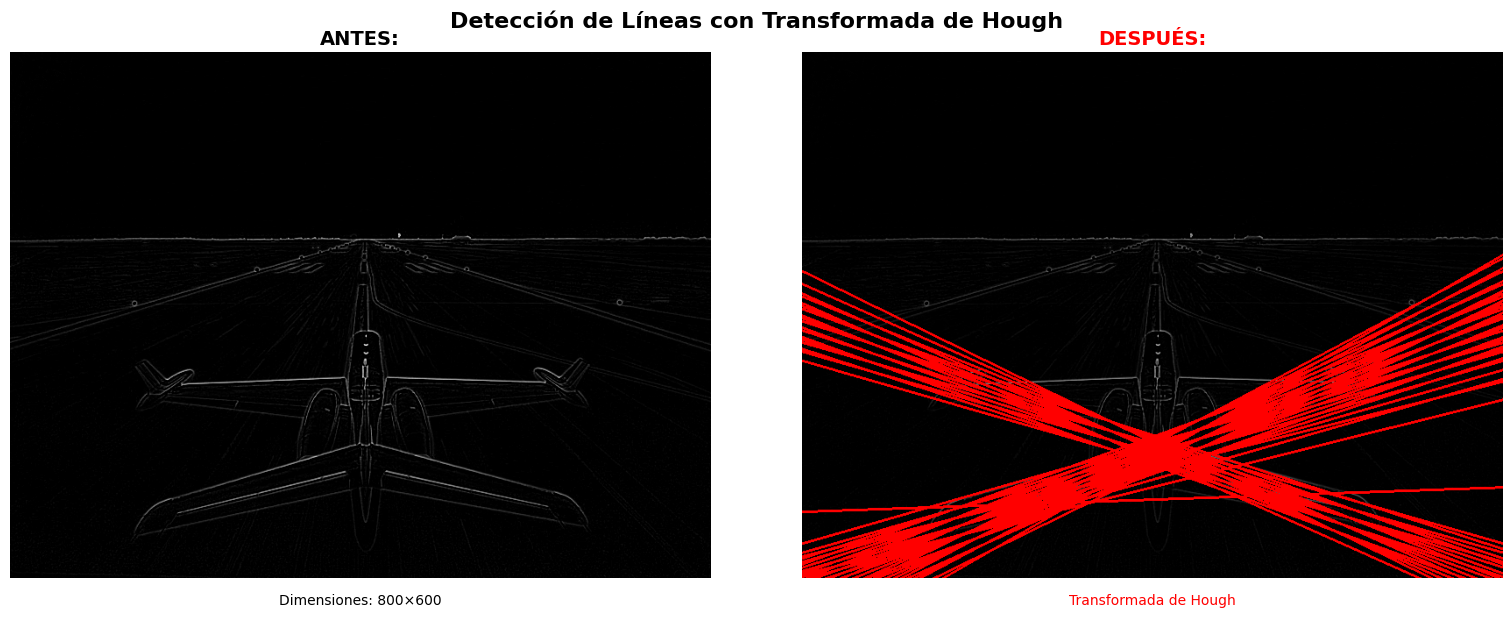

In [65]:
before_and_after(
    pgm_path='/content/Proyecto3-Paralela/runway.pgm',
    png_path='output_shared_lines.png'
)